# Z2-Higgs Model Dynamics

Reproducing Fig. 17 from [arXiv:2409.03747](https://arxiv.org/abs/2409.03747).
### Hamiltonian in (1 + 1)D:

The $Z_2$-Higgs model Hamiltonian is given by:

$$
\hat{H}_{Z_2} = -g \sum_{i=1}^{L-1} \hat{X}_{i,i+1} + U \sum_{i=1}^{L} \hat{n}_i^2 
- J \sum_{i=1}^{L-1} \left( \hat{a}^\dagger_i \hat{Z}_{i,i+1} \hat{a}_{i+1} + \text{h.c.} \right)
$$

We will simulate the Trotterized dynamics for $U = 0$.

---

### Trotterized Evolution:

We evolve initial states using a first-order Trotterization:

$$
e^{-i\hat{H}_{Z_2}t} \approx \left( \hat{U}_1 \hat{U}_2 \right)^r
$$

where $\Delta t = t/r$ and:

1. **Electric field on links:**
   $$
   \hat{U}_1 = \prod_{i} e^{-ig\hat{X}_{i,i+1}\Delta t}
   $$

2. **Hopping term for bosons between sites:**
   $$
   \hat{U}_2 = \prod_{i=1}^{L-1} e^{-iJ\hat{Z}_{i,i+1}(\hat{a}^\dagger_i \hat{a}_{i+1} + \hat{a}_i \hat{a}^\dagger_{i+1})\Delta t}
   $$

---


In [2]:
import sys
import os

# Adjust the path based on your directory structure
module_path = os.path.abspath(os.path.join('..', '..'))  # Moves two directories up
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Now you can import c2qa and other modules from bosonic-qiskit
import c2qa
import qiskit
import numpy as np
import c2qa.util as util
import matplotlib.pyplot as plt
import matplotlib

For some brief motivation of the oscillator-qubit approach, we highlight Sec. V.E of the paper [arXiv:2409.03747](https://arxiv.org/abs/2409.03747) and compare the number of entangling gates required to implement the hopping term in (1+1)D between two sites, in terms of the bosonic Hilbert space cutoff, for hybrid oscillator-qubit architechture and the all-qubit architechture.

- **Hybrid Oscillator-Qubit Model**: This uses a single conditional beam splitter (CBs) defined as 
  $\text{CBs}_{i,j,k}(\phi, \theta) = C_{\Pi_{i,j}} \, \text{Bs}_{j,k}(\phi + \pi/2, \theta) \, C_{\Pi_{i,j}}^\dagger,$
  which is a beam splitter sandwiched between two conditional parity operations. The gate count for this model is constant at 
  $N_\text{hybrid} = 2,$
  with complexity 
  $\mathcal{O}(1).$

- **All-Qubit Model**: This uses Fock binary encoding, where the CNOT count is given by 
  $N_\text{qubit} = 12(2673n^2 + 1160n - 34),$
  with 
  $n = \log_2(N_\text{max} + 1),$
  and \(N_\text{max}\) is the Hilbert space cutoff. The complexity scales as 
  $\mathcal{O}(n^2) = \mathcal{O}(\log(N_\text{max})^2).$

Below, we plot the entangling gate count as a function of the single-site Hilbert space cutoff and the circuit fidelity as a function of entangling gate fidelity for a fixed $N_\text{max} = 2$.

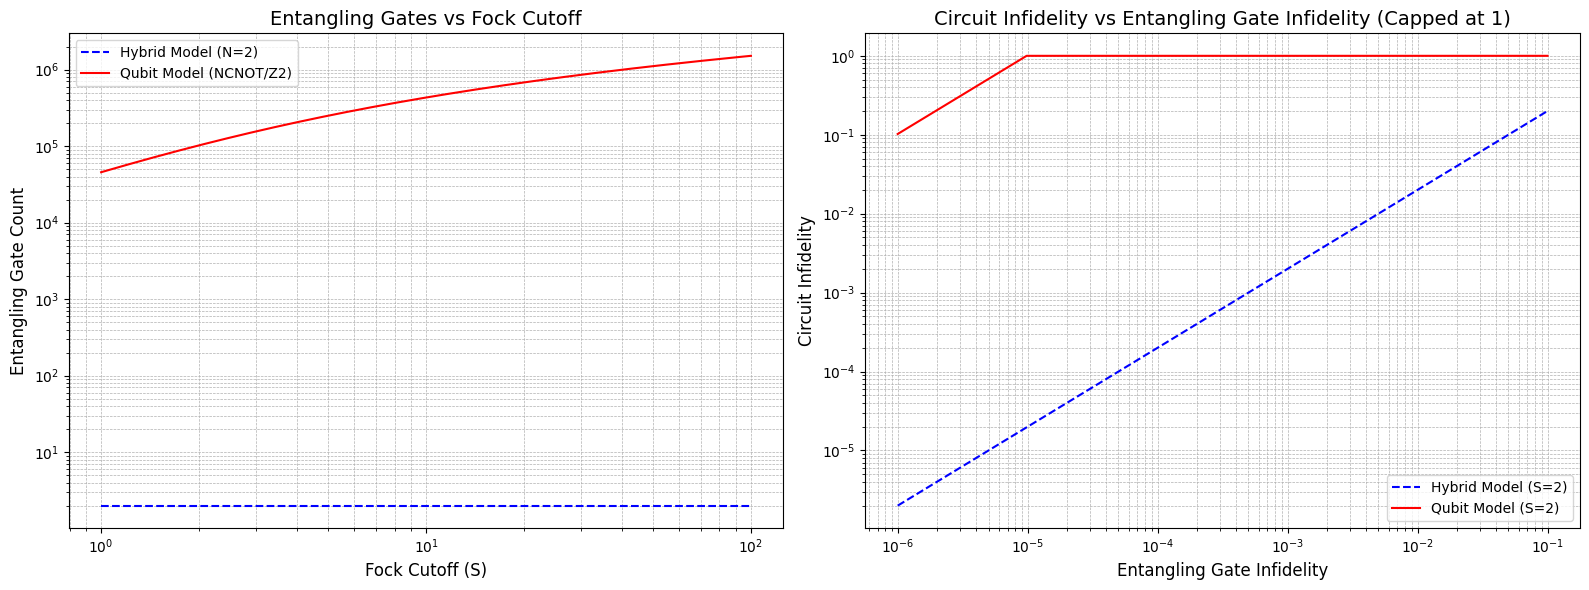

In [6]:
# Define the Fock cutoff range on a log scale
fock_cutoff = np.logspace(0, 2, 500) 

# Define the models
S = fock_cutoff  # Fock cutoff
n = np.log2(S + 1)  

# Hybrid model: constant at N=2
hybrid_gate_count = np.full_like(S, 2)

# Qubit model: N = 12(2673n^2 + 1160n − 34)
qubit_gate_count = 12 * (2673 * n**2 + 1160 * n - 34)

gate_infidelity = np.logspace(-6, -1, 500)

# For S = 2, calculate the number of gates for both models
S_fixed = 2
n_fixed = np.log2(S_fixed + 1)

# Hybrid model: constant gate count at N = 2
hybrid_gate_count_fixed = 2
hybrid_circuit_infidelity = hybrid_gate_count_fixed * gate_infidelity

# Qubit model: N = 12(2673n^2 + 1160n − 34) for fixed S
qubit_gate_count_fixed = 12 * (2673 * n_fixed**2 + 1160 * n_fixed - 34)
qubit_circuit_infidelity = qubit_gate_count_fixed * gate_infidelity

# Cap the circuit infidelity at 1
hybrid_circuit_infidelity_capped = np.minimum(hybrid_circuit_infidelity, 1)
qubit_circuit_infidelity_capped = np.minimum(qubit_circuit_infidelity, 1)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(S, hybrid_gate_count, label="Hybrid Model (N=2)", color='blue', linestyle='--')
axs[0].plot(S, qubit_gate_count, label="Qubit Model (NCNOT/Z2)", color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel("Fock Cutoff (S)", fontsize=12)
axs[0].set_ylabel("Entangling Gate Count", fontsize=12)
axs[0].set_title("Entangling Gates vs Fock Cutoff", fontsize=14)
axs[0].legend(fontsize=10)
axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)

axs[1].plot(gate_infidelity, hybrid_circuit_infidelity_capped, label="Hybrid Model (S=2)", color='blue', linestyle='--')
axs[1].plot(gate_infidelity, qubit_circuit_infidelity_capped, label="Qubit Model (S=2)", color='red')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("Entangling Gate Infidelity", fontsize=12)
axs[1].set_ylabel("Circuit Infidelity", fontsize=12)
axs[1].set_title("Circuit Infidelity vs Entangling Gate Infidelity (Capped at 1)", fontsize=14)
axs[1].legend(fontsize=10)
axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)

# Adjust layout and display
plt.tight_layout()
plt.show()


We consider a $L=5$-site chain prepared in the state $|\psi_0\rangle = |00100\rangle$. The limitation to five sites is not restrictive for short timescales, as the interactions are short-range, and excitations spread with a finite velocity. As long as the “lightcone” does not reach the boundary, the results obtained are the same as in a larger system. The qubits representing the $\mathbb{Z}_2$-Higgs model gauge fields must be initialized according to Gauss’s law, ensuring consistency between the qubits and the parity in each mode. Specifically, with the leftmost gauge field qubit in $|+\rangle$ and the sites in the Fock state $|00100\rangle$, the gauge field qubits on the links between the bosonic sites are initialized in $|++--\rangle$.


In [11]:
# Parameters
numberofmodes = 5
numberofqubits = numberofmodes - 1
numberofqubitspermode = 3
cutoff = 2 ** numberofqubitspermode

# Create registers
qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)  # Qumodes
qbr = qiskit.QuantumRegister(size=numberofqubits)  # Qubits for gauge fields
cbr = qiskit.ClassicalRegister(size=1)  # Classical register for readout
circuit = c2qa.CVCircuit(qmr, qbr, cbr)  # Circuit

# Initialize bosonic modes (Fock state |00100⟩)
fock_states = [0, 0, 1, 0, 0]  # Corresponds to |00100⟩
for i, fock_amplitude in enumerate(fock_states):
    coeffs = [0] * cutoff  # Initialize all coefficients to 0
    coeffs[fock_amplitude] = 1  # Set the amplitude for the desired Fock state
    circuit.cv_initialize(coeffs, qmr[i])  # Initialize each qumode

# Initialize qubits (|++--⟩)
plus_state = [1 / np.sqrt(2), 1 / np.sqrt(2)]  # Coefficients for |+⟩
minus_state = [1 / np.sqrt(2), -1 / np.sqrt(2)]  # Coefficients for |−⟩

# Apply initialization to each qubit
for i in range(numberofqubits):
    if i < 2:  # First two qubits to |+⟩
        circuit.initialize(plus_state, qbr[i])
    else:  # Last two qubits to |−⟩
        circuit.initialize(minus_state, qbr[i])


# Draw the circuit for visualization
# circuit.draw('mpl')

# state0, _, _ = c2qa.util.simulate(circuit)
# print(state0)

Now we need to define the gate sequence correspoding to a single Trotter step.